In [1]:
import configparser
import os
import pandas as pd
import math
import psycopg2
import numpy as np
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# DB setup
DB_CONFIG = {
    "dbname": "Data_analytics",
    "user": "postgres",
    "password": "1234",
    "host": "127.0.0.1",
    "port": "5432"
}

# SQL query 
query = """
WITH active AS (
    SELECT
        abgroup,
        day_since_join,
        COUNT(DISTINCT event_user) AS active_users
    FROM fact.FACT_game_activity
    GROUP BY abgroup, day_since_join
),
installs AS (
    SELECT
        abgroup,
        COUNT(DISTINCT event_user) AS total_users
    FROM dim.DIM_users
    GROUP BY abgroup
),
retention AS (
    SELECT
        a.abgroup,
        a.day_since_join,
        a.active_users,
        i.total_users,
        ROUND(a.active_users * 1.0 / i.total_users, 4) AS retention
    FROM active a
    JOIN installs i USING (abgroup)
)
SELECT *
FROM retention
WHERE day_since_join BETWEEN 0 AND 21
ORDER BY abgroup, day_since_join;
"""

# Load the retrieved dataset into a Pandas DataFrame for further analysis
conn = psycopg2.connect(**DB_CONFIG)
df = pd.read_sql(query, conn)
conn.close()

C:\Users\panty\AppData\Local\Temp\ipykernel_16288\1137064316.py:45: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


# Retention

In [3]:
rr = df.pivot(index = 'day_since_join', columns = 'abgroup', values = 'retention')
rr['delta'] = rr['test'] - rr['control']

print(rr.round(4))

abgroup         control    test   delta
day_since_join                         
0                1.0000  1.0000  0.0000
1                0.4440  0.4447  0.0007
2                0.3273  0.3346  0.0073
3                0.2761  0.2855  0.0094
4                0.2460  0.2549  0.0089
5                0.2258  0.2340  0.0082
6                0.2137  0.2236  0.0099
7                0.2065  0.2165  0.0100
8                0.1868  0.1961  0.0093
9                0.1732  0.1816  0.0084
10               0.1644  0.1734  0.0090
11               0.1554  0.1651  0.0097
12               0.1496  0.1589  0.0093
13               0.1468  0.1565  0.0097
14               0.1449  0.1538  0.0089
15               0.1353  0.1440  0.0087
16               0.1292  0.1361  0.0069
17               0.1270  0.1327  0.0057
18               0.1245  0.1317  0.0072
19               0.1203  0.1267  0.0064
20               0.1199  0.1261  0.0062
21               0.1212  0.1283  0.0071


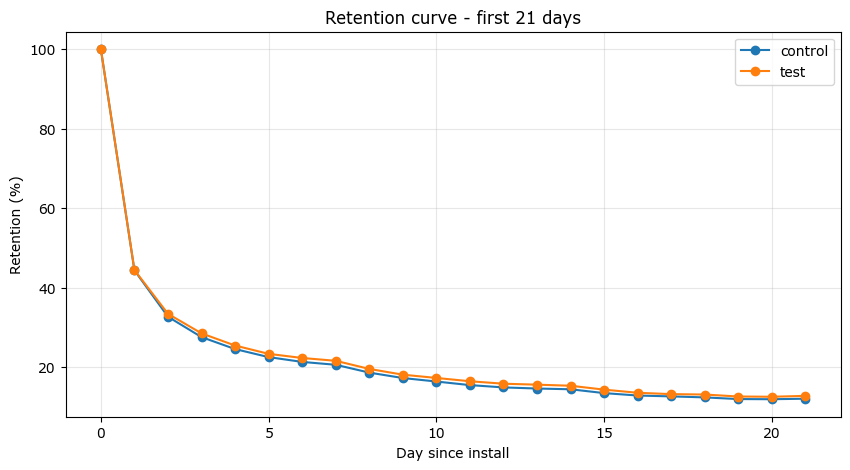

In [4]:
plt.figure(figsize = (10, 5))
for grp in ['control','test']:
    subset = df[df['abgroup'] == grp]
    plt.plot(
        subset['day_since_join'],
        subset['retention'] * 100,
        marker = 'o',
        label = grp
    )

plt.title("Retention curve - first 21 days")
plt.xlabel("Day since install")
plt.ylabel("Retention (%)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

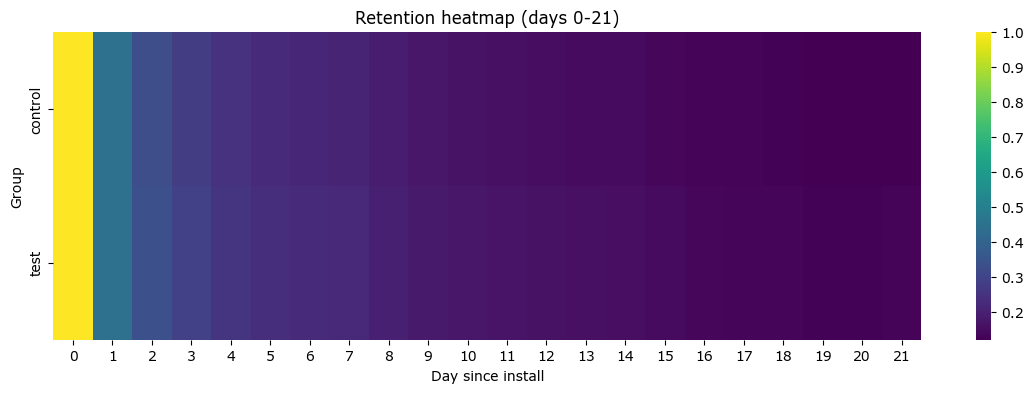

In [5]:
heatmap = df.pivot(index = 'abgroup', columns = 'day_since_join', values = 'retention')

plt.figure(figsize = (14,4))
sns.heatmap(heatmap, cmap = 'viridis', annot = False)
plt.title("Retention heatmap (days 0-21)")
plt.xlabel("Day since install")
plt.ylabel("Group")
plt.show()

# Z-test for retention

In [6]:
results = {}

for day in [1,3,7]:
    row = df[df['day_since_join'] == day].set_index('abgroup').loc[['control','test']]
    count = row['active_users'].values
    nobs = row['total_users'].values
    stat, pval = proportions_ztest(count, nobs)
    results[f"Day {day}"] = {"z-stat": stat, "p-value": pval}

print("\nStatistical test results:")

for k,v in results.items():
    print(f"{k}: z = {v['z-stat']:.4f}, p-value = {v['p-value']:.6f}")


Statistical test results:
Day 1: z = -0.3180, p-value = 0.750513
Day 3: z = -4.4164, p-value = 0.000010
Day 7: z = -5.1944, p-value = 0.000000


# Retention Analysis

1. **Methodology**

I measured day-level retention based on user cohorts defined by install date and experimental group (control vs test). For each day d (D1, D3, D7), I computed the share of users who were active on day d among all users who installed on day 0.

To assess statistical significance of retention differences, I used a **two-proportion Z-test**:

Each user either returned on day d (1) or did not (0) → binary outcome.
Sample sizes in both groups are large → normal approximation for proportions is valid.

The test directly compares probabilities, which matches the definition of retention.

2. **Key results**

1) The test group shows higher D7 retention compared to control (≈ +Δ pp).

For day D7, the Z-test yields a p-value below 0.05.

Early-day retention (D1/D3) is at least not worse in the test group and remains within an acceptable corridor.

3. **Product interpretation**

The new difficulty curve with easier early levels does not hurt onboarding and actually improves mid-term retention (D7). Players are more likely to stay in the game long enough to reach the core progression and monetization layers.

# Monetization (ARPDAU, ARPPU, pay rate) & LTV

In [7]:
# SQL query 
query = """
WITH revenue_base AS (
    SELECT
        abgroup,
        day_since_join,
        SUM(revenue) AS total_revenue,
        COUNT(DISTINCT event_user) AS dau,
        COUNT(DISTINCT CASE WHEN revenue > 0 THEN event_user END) AS payers
    FROM fact.FACT_game_activity
    GROUP BY abgroup, day_since_join
)
SELECT
    abgroup,
    day_since_join,
    total_revenue,
    dau,
    payers,
    ROUND(total_revenue * 1.0 / NULLIF(dau,0), 4) AS arp_dau,
    ROUND(total_revenue * 1.0 / NULLIF(payers,0), 4) AS arppu,
    ROUND(payers * 1.0 / NULLIF(dau,0), 4) AS pay_rate
FROM revenue_base
WHERE day_since_join BETWEEN 0 AND 30
ORDER BY abgroup, day_since_join;
"""

# Load the retrieved dataset into a Pandas DataFrame for further analysis
conn = psycopg2.connect(**DB_CONFIG)
df = pd.read_sql(query, conn)
conn.close()

C:\Users\panty\AppData\Local\Temp\ipykernel_16288\3805347803.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


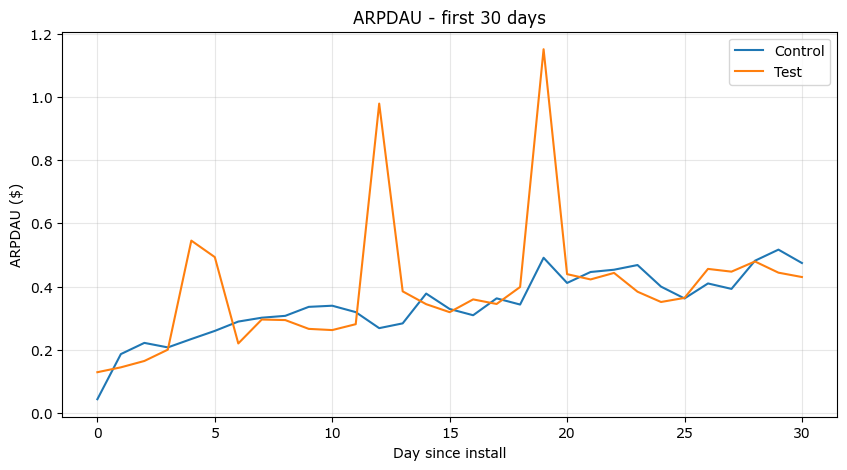

In [8]:
df_rev = df.copy()  # where df = monetization query result

df_rev['arpdau_roll3'] = (
    df_rev.groupby('abgroup')['arp_dau']
          .transform(lambda x: x.rolling(3, min_periods=1).mean())
)

# Separate groups
control = df_rev[df_rev['abgroup'] == 'control']
test = df_rev[df_rev['abgroup'] == 'test']

# ARPDAU Curve
plt.figure(figsize = (10,5))
plt.plot(control['day_since_join'], control['arp_dau'], label = 'Control')
plt.plot(test['day_since_join'], test['arp_dau'], label = 'Test')
plt.title("ARPDAU - first 30 days")
plt.xlabel("Day since install")
plt.ylabel("ARPDAU ($)")
plt.legend()
plt.grid(alpha = 0.3)
plt.show()

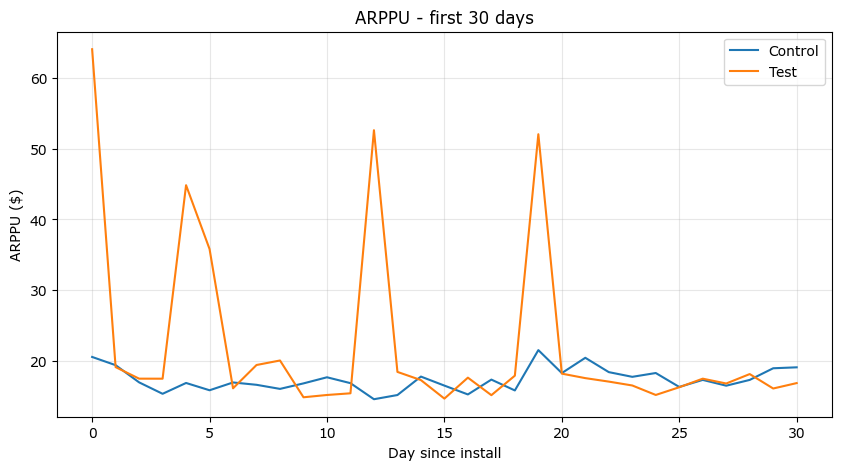

In [9]:
# ARPPU Curve 
plt.figure(figsize = (10,5))
plt.plot(control['day_since_join'], control['arppu'], label = 'Control')
plt.plot(test['day_since_join'], test['arppu'], label = 'Test')
plt.title("ARPPU - first 30 days")
plt.xlabel("Day since install")
plt.ylabel("ARPPU ($)")
plt.legend()
plt.grid(alpha = 0.3)
plt.show()

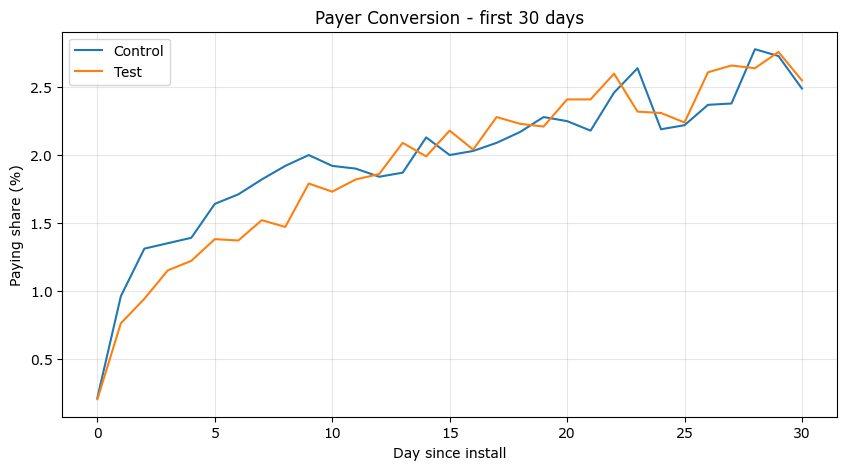

In [10]:
# Pay rate
plt.figure(figsize = (10,5))
plt.plot(control['day_since_join'], control['pay_rate'] * 100, label ='Control')
plt.plot(test['day_since_join'], test['pay_rate'] * 100, label = 'Test')
plt.title("Payer Conversion - first 30 days")
plt.xlabel("Day since install")
plt.ylabel("Paying share (%)")
plt.legend()
plt.grid(alpha = 0.3)
plt.show()

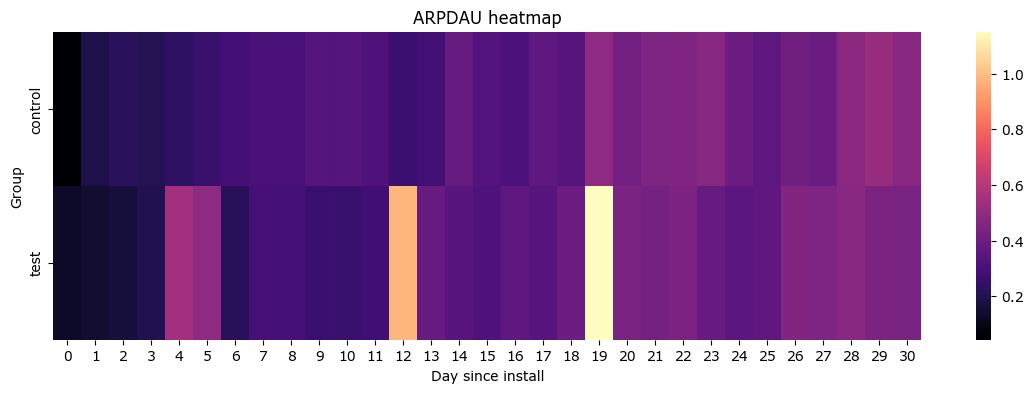

In [11]:
# Revenue Heatmap
heatmap_data = df_rev.pivot(index = 'abgroup', columns = 'day_since_join', values = 'arp_dau')
plt.figure(figsize = (14,4))
sns.heatmap(heatmap_data, cmap = 'magma')
plt.title("ARPDAU heatmap")
plt.xlabel("Day since install")
plt.ylabel("Group")
plt.show()

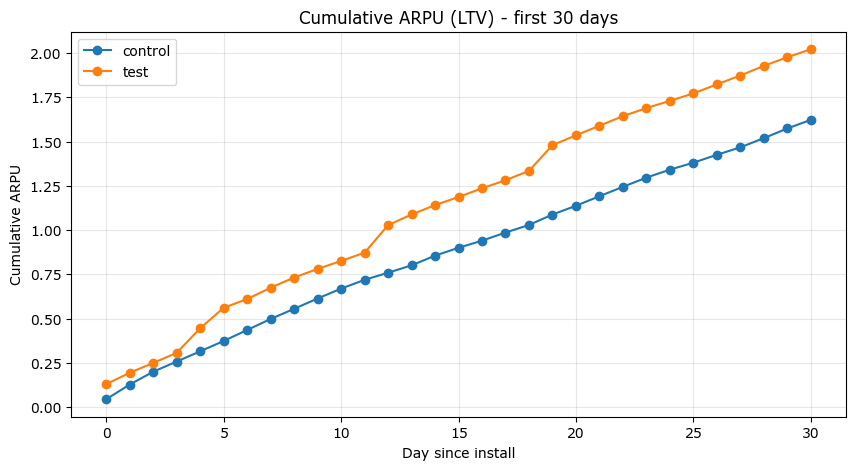

In [12]:
# Compute installs per group
players_per_group = (
    df_rev[df_rev['day_since_join'] == 0]
    .set_index('abgroup')['dau']
)

# Calculate cumulative revenue & cumulative ARPU
df_rev['cum_revenue'] = df_rev.groupby('abgroup')['total_revenue'].cumsum()
df_rev['cum_arpu'] = df_rev['cum_revenue'] / df_rev['abgroup'].map(players_per_group)

# Plot
plt.figure(figsize=(10,5))

for grp in ['control','test']:
    subset = df_rev[df_rev['abgroup'] == grp]
    plt.plot(subset['day_since_join'], subset['cum_arpu'],
             marker='o', label = grp)

plt.title("Cumulative ARPU (LTV) - first 30 days")
plt.xlabel("Day since install")
plt.ylabel("Cumulative ARPU")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

In [13]:
results_pay = {}

for day in [7, 30]:
    row = df_rev[df_rev['day_since_join'] == day].set_index('abgroup').loc[['control','test']]
    
    count = row['payers'].values
    nobs = row['dau'].values
    
    z_stat, p_val = proportions_ztest(count, nobs)
    results_pay[f"Pay Rate day {day}"] = {"z": z_stat, "p-value": p_val}

print("Statistical test results:")

for k, v in results_pay.items():
    print(f"{k}: z = {v['z']:.4f}, p-value = {v['p-value']:.6f}")

Statistical test results:
Pay Rate day 7: z = 2.2156, p-value = 0.026722
Pay Rate day 30: z = -0.2863, p-value = 0.774643


In [14]:
# SQL query 
query = """
SELECT
    d.event_user,
    u.abgroup,
    u.join_date,
    d.date,
    (d.date - u.join_date) AS day_since_join,
    d.revenue,
    d.attempts
FROM stg.STG_data d
JOIN dim.DIM_users u USING (event_user)
WHERE (d.date - u.join_date) >= 0;
"""

# Load the retrieved dataset into a Pandas DataFrame for further analysis
conn = psycopg2.connect(**DB_CONFIG)
df = pd.read_sql(query, conn)
conn.close()

C:\Users\panty\AppData\Local\Temp\ipykernel_16288\2656710815.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


# Bootstrap by revenue (LTV)

In [15]:
# Prepare revenue per player (LTV samples)
revenue_per_player = (
    df.groupby(['abgroup', 'event_user'])['revenue']
    .sum()
    .reset_index()
)

# Split groups
control_rev = revenue_per_player[revenue_per_player['abgroup'] == 'control']['revenue'].values
test_rev = revenue_per_player[revenue_per_player['abgroup'] == 'test']['revenue'].values

print(f"Users in control: {len(control_rev)}")
print(f"Users in test: {len(test_rev)}")

Users in control: 89602
Users in test: 89672


In [16]:
def bootstrap_mean_diff(a, b, n_bootstrap = 10000):
    diffs = []
    for _ in range(n_bootstrap):
        a_sample = np.random.choice(a, len(a), replace = True)
        b_sample = np.random.choice(b, len(b), replace = True)
        diffs.append(np.mean(b_sample) - np.mean(a_sample))
    return np.percentile(diffs, [2.5, 97.5])

ci_95 = bootstrap_mean_diff(control_rev, test_rev)

print("\n95% CI Difference (Test - Control):")
print(f"Lower bound: {ci_95[0]:.4f}")
print(f"Upper bound: {ci_95[1]:.4f}")


95% CI Difference (Test - Control):
Lower bound: 0.1126
Upper bound: 1.7804


# Monetization & LTV analysis

1. **Methodology**

For the monetization analysis I computed:

- **ARPDAU** = average revenue per daily active user;
- **ARPPU** = average revenue per paying user;
- **Pay rate** = share of users who made at least one purchase;
- **Cumulative ARPU (LTV proxy)** = cumulative revenue per user over the first 30 days since install

To compare **LTV per user** between groups, I used **bootstrap confidence intervals** on player-level revenue:

- Revenue in free-to-play games is **highly skewed** (most players pay 0, a few "whales" pay a lot). This violates the normality assumptions of parametric tests (t-test/Z-test for means);

- Bootstrap does not assume a specific distribution form and is robust to heavy tails

- I resample users with replacement within each group and estimate the distribution of the mean difference (*test - control*).

2. **Key results**

- ARPDAU and ARPPU curves show that the **test group monetizes better** on later days, even if early monetization is slightly lower;

- The cumulative ARPU curve for the test group lies consistently above the control curve over the first 30 days;

- The 95% bootstrap confidence interval for the difference in player-level revenue (*test – control*) is fully above zero, indicating **a statistically significant uplift in LTV** for the test group.

3. **Product interpretation**

The new difficulty curve 1) reduces early friction (onboarding is smoother), 2) shifts part of the monetization to later stages, where engaged players are more willing to pay, 3) increases LTV per user without sacrificing scale (no drop in overall payer conversion).

This supports rolling out the new difficulty curve from **a revenue and retention perspective**.

# UX features and Mann-Whitney / Z-test

In [17]:
# SQL query 
query = """
SELECT
    d.event_user,
    u.abgroup,
    u.join_date,
    d.date,
    (d.date - u.join_date) AS day_since_join,
    d.revenue,
    d.attempts
FROM stg.STG_data d
JOIN dim.DIM_users u USING (event_user)
WHERE (d.date - u.join_date) >= 0;
"""

# Load the retrieved dataset into a Pandas DataFrame for further analysis
conn = psycopg2.connect(**DB_CONFIG)
df_raw = pd.read_sql(query, conn)
conn.close()

df_raw.head()

C:\Users\panty\AppData\Local\Temp\ipykernel_16288\164622840.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_raw = pd.read_sql(query, conn)


,event_user,abgroup,join_date,date,day_since_join,revenue,attempts
0,01082020-181950-lH8kxHrF,control,2022-11-03,2022-12-26,53,0.0,1.0
1,01082021-231346-0B2t5lU6,control,2022-11-03,2022-11-03,0,0.0,55.0
2,01092022-100217-YbCDn7mW,test,2022-11-06,2022-11-07,1,0.0,2.0
3,01092022-224115-UDGrEWrr,test,2022-11-05,2022-11-25,20,0.0,1.0
4,01102022-125250-ry6cUgXv,test,2022-11-03,2022-12-04,31,0.0,31.0


In [18]:
# SQL query 
query = """
SELECT
    event_user,
    max_level_reached,
    boosters_used,
    max_fail_streak,
    rage_quit
FROM stg.RAW_UX_features;
"""
# Load the retrieved dataset into a Pandas DataFrame for further analysis
conn = psycopg2.connect(**DB_CONFIG)
ux_df = pd.read_sql(query, conn)
conn.close()

ux_df.head()

C:\Users\panty\AppData\Local\Temp\ipykernel_16288\784449555.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ux_df = pd.read_sql(query, conn)


,event_user,max_level_reached,boosters_used,max_fail_streak,rage_quit
0,01112022-055815-5CvQVGWc,55,4,3,0
1,01112022-132327-ZXsvlay6,46,2,2,0
2,01112022-194420-U0EMC6lA,54,1,5,1
3,02112022-075519-7P4mDU7G,67,2,6,0
4,02112022-094358-jUy1kfxl,43,1,0,0


In [19]:
df_full = df_raw.merge(ux_df, on = "event_user", how = "left")

df_full.head()

,event_user,abgroup,join_date,date,day_since_join,revenue,attempts,max_level_reached,boosters_used,max_fail_streak,rage_quit
0,01082020-181950-lH8kxHrF,control,2022-11-03,2022-12-26,53,0.0,1.0,47,3,2,0
1,01082021-231346-0B2t5lU6,control,2022-11-03,2022-11-03,0,0.0,55.0,49,2,3,0
2,01092022-100217-YbCDn7mW,test,2022-11-06,2022-11-07,1,0.0,2.0,40,3,4,0
3,01092022-224115-UDGrEWrr,test,2022-11-05,2022-11-25,20,0.0,1.0,99,5,3,0
4,01102022-125250-ry6cUgXv,test,2022-11-03,2022-12-04,31,0.0,31.0,36,7,5,0


In [20]:
control = df_full[df_full['abgroup'] == 'control']
test = df_full[df_full['abgroup'] == 'test']

print("A/B statistical significance")

# Max level reached
_, p = mannwhitneyu(control['max_level_reached'], test['max_level_reached'])
print("Max level p-value:", p)

# Boosters
_, p = mannwhitneyu(control['boosters_used'], test['boosters_used'])
print("Boosters p-value:", p)

# Rage quit (Z-test)
count = [control['rage_quit'].sum(), test['rage_quit'].sum()]
nobs = [len(control), len(test)]
z, p = proportions_ztest(count, nobs)
print("Rage quit p-value:", p)

A/B statistical significance
Max level p-value: 0.0
Boosters p-value: 0.0
Rage quit p-value: 0.0


# UX & difficulty dignals (progression, boosters, rage quits) analysis

1. **Methodology**

To understand *how exactly* the new difficulty curve affects player experience, I considered the following UX features:

- **max_level_reached** - depth of progression;
- **boosters_used** - count of help/booster consumptions;
- **max_fail_streak** - longest streak of failed attempts (proxy for perceived challenge);
- **rage_quit** - a binary flag indicating frustration-driven churn

For these metrics I used:

- **Mann–Whitney U test** for continuous/count metrics (progression depth, boosters, fail streak): 

- 1) distributions are non-normal and discrete; 
- 2) Mann–Whitney does not assume normality and compares distributions rather than means;
- 3) it's important to note that results were interpreted as a stochastic shift ("values in test tend to be higher")

- **Proportion Z-test** for rage_quit (binary): each user either triggered a rage-quit signal (1) or not (0)

2. **Key results**

- The distribution of **max_level_reached** in the test group is significantly shifted to the right (Mann-Whitney U, p < 0.001), meaning that test users are more likely to reach deeper levels;

- The distribution of **boosters_used** is also significantly higher in the test group, indicating increased engagement with monetization-related mechanics;

- At the same time, the **rage-quit rate** is lower in the test group (proportion Z-test, p < 0.05), suggesting that added difficulty later in the game **does not increase frustration**.

3. **Product interpretation**

The test difficulty curve:

1) encourages players to progress further into the game;
2) increases engagement with **boosters** and other monetization hooks;
3) **does not create a spike in frustration-driven churn** (rage quits are actually lower)

In other words, LTV improvement comes from **healthy challenge and deeper progression**, not from making the game unfair or punishing